In [19]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic


In [20]:
pos_data, pos_label = basic.preprocess_data("/home/moamin/sequence_annotation_seawulf/gene_range_start_codon.txt", 1)
neg_data, neg_label = basic.preprocess_data("/home/moamin/sequence_annotation_seawulf/intragenic_start_codon.txt", 0)

In [21]:
print(len(pos_data), len(neg_data))
print(pos_label[0], neg_label[0])
data_size = 5000
batch_size = 1000

8385 13683
1 0


In [4]:
data_content = pos_data[:data_size] + neg_data[:data_size]
data_label = pos_label[:data_size] + neg_label[:data_size] 
print(len(data_content), np.sum(data_label))

rand_index = np.random.permutation(len(data_content))
data_content = [data_content[i] for i in rand_index]
data_label = [data_label[i] for i in rand_index]
print(len(data_content), np.sum(data_label))
'''
for i in range(len(data_label)):
    if data_label[i] == 1:
        data_content[i] = [data_content[i][0] for k in data_content[i]]
'''

10000 5000
10000 5000


'\nfor i in range(len(data_label)):\n    if data_label[i] == 1:\n        data_content[i] = [data_content[i][0] for k in data_content[i]]\n'

In [5]:
np.array(data_content)

array([['4', '2', '2', ..., '1', '1', '2'],
       ['1', '1', '1', ..., '1', '3', '3'],
       ['2', '4', '3', ..., '2', '2', '1'],
       ...,
       ['2', '1', '3', ..., '3', '4', '2'],
       ['1', '1', '1', ..., '1', '4', '3'],
       ['4', '2', '1', ..., '4', '4', '3']], dtype='<U1')

In [6]:
np.array(data_label)

array([1, 0, 1, ..., 1, 0, 1])

## Pytorch base line model

In [7]:
X = torch.from_numpy(np.array(data_content).astype(int))
Y = torch.from_numpy(np.array(data_label).reshape(len(data_label),1).astype(int))
X.shape, Y.shape

(torch.Size([10000, 101]), torch.Size([10000, 1]))

In [8]:
class LSTMTagger(nn.Module):

    def __init__(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch):
        super(LSTMTagger, self).__init__()
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.mini_batch = mini_batch
        self.hidden = self.init_hidden()
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_one = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout_one = nn.Dropout(0.25)
        self.lstm_two = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout_two = nn.Dropout(0.25)

        # The linear layer that maps from hidden state space to tag space
        #self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_three = nn.Dropout(0.25)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_four = nn.Dropout(0.25)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_five = nn.Dropout(0.25)
        
        self.output = nn.Linear(64, tagset_size)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.mini_batch, self.hidden_dim),
                torch.zeros(1, self.mini_batch, self.hidden_dim))
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)#.view(len(sentence), self.mini_batch, -1)
        lstm_out, self.hidden_one = self.lstm_one(embeds, self.hidden)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden)
        lstm_out = self.dropout_two(lstm_out)
        
        #print(lstm_out.shape)
        #print(self.hidden)
        
        #print(lstm_out[:, -1].shape)
        #tag_space = self.hidden2tag(lstm_out[:, -1])
        
        lstm_out = lstm_out.contiguous().view(self.mini_batch, -1)
        #print(lstm_out.shape)
        
        
        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_three(dense_out[:])
        
        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])
        
        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])
        
        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        #tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_space


In [9]:
model = LSTMTagger(101, 16, 16, 5, 1, batch_size)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

LSTMTagger(
  (word_embeddings): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (hidden2tag_one): Linear(in_features=1616, out_features=512, bias=True)
  (dropout_three): Dropout(p=0.25)
  (hidden2tag_two): Linear(in_features=512, out_features=128, bias=True)
  (dropout_four): Dropout(p=0.25)
  (hidden2tag_three): Linear(in_features=128, out_features=64, bias=True)
  (dropout_five): Dropout(p=0.25)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [10]:
import torch.nn.functional as F

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [11]:
from tqdm import tqdm_notebook as tqdm
losses = []
accuracies = []

for epoch in tqdm(range(10)):  # again, normally you would NOT do 300 epochs, it is toy data
    total_loss = 0
    total_acc = 0
    
    for index in range(0, len(X), batch_size):
        sentence = X[index : index+batch_size]
        tags = Y[index : index+batch_size]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        targets = tags.float().flatten()

        # Step 3. Run our forward pass.
        tag_scores = model(sentence).flatten()
        #print(targets.shape, tag_scores.shape)
        

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(tag_scores, targets)
        total_loss += loss.data.numpy()
        
        #acc = binary_accuracy(tag_scores, targets)
        #total_acc += acc
        
        loss.backward()
        optimizer.step()
        
    #total_loss.backward()
    #opt.step()
    print(epoch, total_loss)#, total_acc)
        
    losses.append(total_loss/len(X))
    #accuracies.append(total_acc/(len(X)/batch_size))
        

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


0 6.905844330787659
1 6.276926755905151
2 4.5275969207286835
3 3.816814213991165
4 3.4273089468479156
5 3.1447725892066956
6 2.886026829481125
7 2.6899381577968597
8 2.4794205725193024
9 2.356536343693733



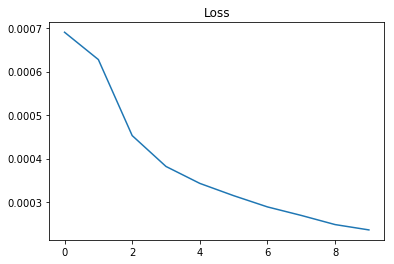

In [12]:
plt.title("Loss")
plt.plot(losses)
#plt.title("Accuracies")
#plt.plot(accuracies)

# Keras Implementation

In [22]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
embedding_size = 4
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


In [24]:
data_content = pos_data[:data_size] + neg_data[:data_size]
data_label = pos_label[:data_size] + neg_label[:data_size] 
print(len(data_content), np.sum(data_label))

10000 5000


In [25]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

max_source_len = len(data_content[0])
embedding_size = 5
lstm_unit = 16

input_source = Input(shape=(max_source_len,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source_len, \
                      name='embedding')(input_source)

lstm_layer = LSTM(lstm_unit, return_sequences=True)(embedding)
lstm_layer = Dropout(0.25)(lstm_layer)
lstm_layer = LSTM(lstm_unit, return_sequences=True)(lstm_layer)
lstm_layer = Dropout(0.25)(lstm_layer)

reshape_layer = Reshape((max_source_len*lstm_unit,))(lstm_layer)

dense_layer_first = Dense(512, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(1, activation='sigmoid', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 101)               0         
_________________________________________________________________
embedding (Embedding)        (None, 101, 5)            30        
_________________________________________________________________
lstm_3 (LSTM)                (None, 101, 16)           1408      
_________________________________________________________________
dropout_6 (Dropout)          (None, 101, 16)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 101, 16)           2112      
_________________________________________________________________
dropout_7 (Dropout)          (None, 101, 16)           0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1616)              0         
__________

In [26]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(np.array(data_content), np.array(data_label), \
          validation_split=0.2, shuffle=True, \
          epochs=10, batch_size=batch_size, verbose=2, \
           callbacks=[TQDMNotebookCallback()])


Train...
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
 - 6s - loss: 0.6758 - acc: 0.6120 - val_loss: 1.0434 - val_acc: 0.0000e+00
Epoch 2/10
 - 4s - loss: 0.6385 - acc: 0.6249 - val_loss: 0.9676 - val_acc: 0.0060
Epoch 3/10
 - 4s - loss: 0.5454 - acc: 0.7128 - val_loss: 1.0900 - val_acc: 0.5095
Epoch 4/10
 - 4s - loss: 0.4675 - acc: 0.7959 - val_loss: 0.9244 - val_acc: 0.6725
Epoch 5/10
 - 4s - loss: 0.4214 - acc: 0.8144 - val_loss: 1.1974 - val_acc: 0.4945
Epoch 6/10
 - 4s - loss: 0.3991 - acc: 0.8260 - val_loss: 1.0667 - val_acc: 0.5820
Epoch 7/10
 - 4s - loss: 0.3722 - acc: 0.8382 - val_loss: 0.8856 - val_acc: 0.6405
Epoch 8/10
 - 4s - loss: 0.3584 - acc: 0.8502 - val_loss: 0.9297 - val_acc: 0.6275
Epoch 9/10
 - 4s - loss: 0.3418 - acc: 0.8556 - val_loss: 0.7261 - val_acc: 0.6980
Epoch 10/10
 - 4s - loss: 0.3289 - acc: 0.8607 - val_loss: 0.8224 - val_acc: 0.6885



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
11 11


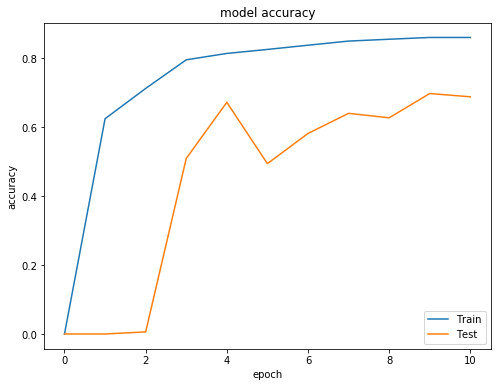

In [27]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['acc']
valid = history.history['val_acc']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
11 11


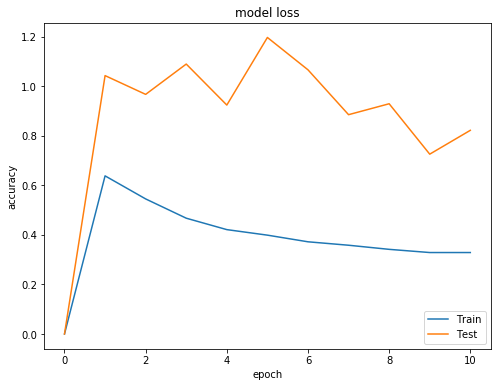

In [28]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['loss']
valid = history.history['val_loss']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
